__Problem Statement:__ To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, LayerNormalization


In [2]:
## If you are using the data by mounting the google drive, use the following :
## from google.colab import drive
## drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [2]:
#local
#root_path = '/Users/hkolavasi/Documents/playground/NN/CNN'
#colab
root_path = '/content/gdrive/MyDrive/UpGrad_melanoma_detection_assignment'
os.listdir(root_path)

['Building+a+CNN+-+MNIST.ipynb',
 'Skin cancer ISIC The International Skin Imaging Collaboration',
 '.DS_Store',
 'CNN_assignment.zip',
 '.ipynb_checkpoints',
 'RNN',
 '1.+Cifar_10_with_dropout_without_BN.ipynb',
 '1409.1556v6.pdf',
 'Hari_Kolavasi_CNN_Assignment.ipynb']

In [3]:

os.chdir(root_path)  #change dir

assignment_dir = os.getcwd()

print(os.listdir(assignment_dir))

!mkdir melanoma_detection_assignment_final

##unzip file
!unzip -q CNN_assignment.zip -d melanoma_detection_assignment_final

['Building+a+CNN+-+MNIST.ipynb', 'Skin cancer ISIC The International Skin Imaging Collaboration', '.DS_Store', 'CNN_assignment.zip', '.ipynb_checkpoints', 'RNN', '1.+Cifar_10_with_dropout_without_BN.ipynb', '1409.1556v6.pdf', 'Hari_Kolavasi_CNN_Assignment.ipynb']


In [56]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset

data_dir = root_path + '/melanoma_detection_assignment_final/Skin cancer ISIC The International Skin Imaging Collaboration/'

data_dir_train = pathlib.Path(data_dir + 'Train')
data_dir_test = pathlib.Path(data_dir + 'Test')

In [5]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


In [6]:
# model
num_classes = 9
def buildModel(input_shape, data_augmentation, layerActivation, outputActivation, dropout, filters, layerNormalization):
  args = []
  firstLayer = True
  if data_augmentation:
    args.append(data_augmentation)
  args.append(layers.Rescaling(1./255, input_shape=input_shape))
  model = Sequential(args)

  for f in filters:
    if firstLayer:
      # first layer needs to be told the input shape explicitly
      model.add(Conv2D(f, kernel_size=(3, 3),
                  activation=layerActivation,
                  input_shape=input_shape)) # input shape = (img_rows, img_cols, 1)
      firstLayer = False
    else:
      model.add(Conv2D(f, kernel_size=(3, 3),
                  activation=layerActivation))

  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(dropout))

  # flatten and put a fully connected layer
  model.add(Flatten())
  model.add(Dense(128, activation=layerActivation)) # fully connected
  model.add(Dropout(dropout))
  if layerNormalization:
    model.add(LayerNormalization())
  # softmax layer
  model.add(Dense(num_classes, activation=outputActivation))
  return model

### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

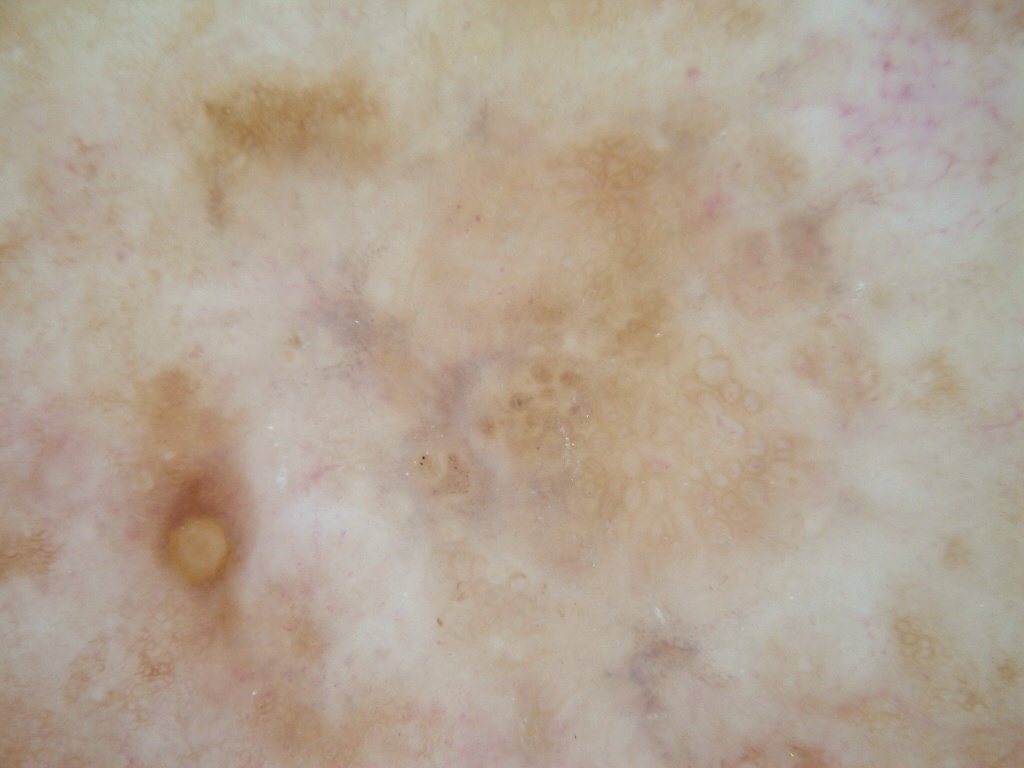

In [7]:
import PIL
##checking images, if we are able to load
melanoma = list(data_dir_train.glob('melanoma/*'))
PIL.Image.open(str(melanoma[0]))

### Create a dataset

Define some parameters for the loader:

In [8]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [9]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [10]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


In [11]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
validation_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [12]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
validation_class_names = validation_ds.class_names
print(validation_class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

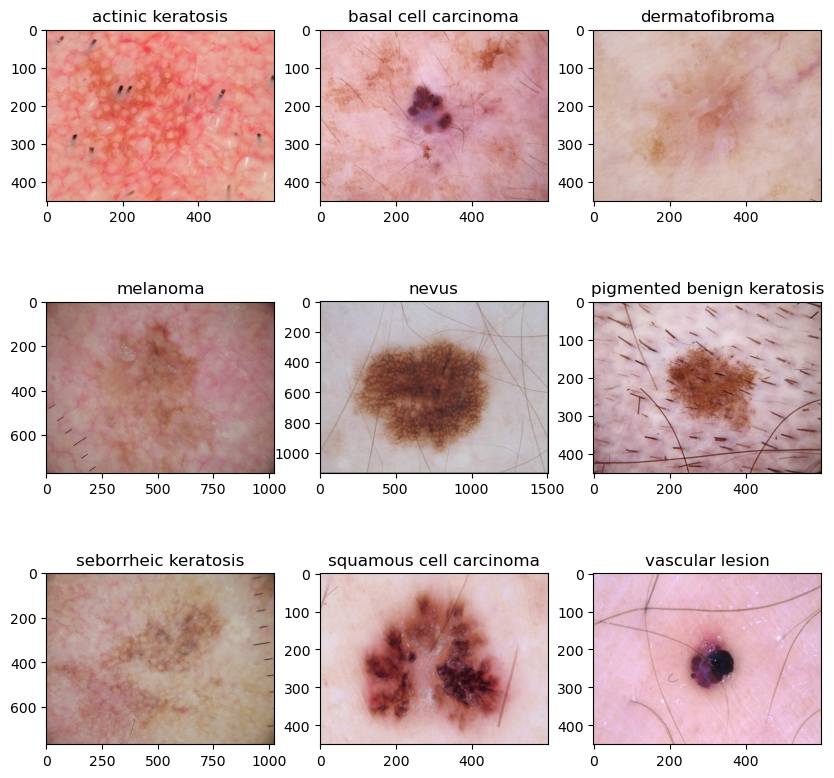

In [13]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

### your code goes here, you can use training or validation data to visualize

plt.figure(figsize=(10,10))
for i in range(9):
  plt.subplot(3, 3, i + 1)
  image = mpimg.imread(str(list(data_dir_train.glob(class_names[i]+'/*.jpg'))[1]))
  plt.title(class_names[i])
  plt.imshow(image)

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [14]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
validation_ds = validation_ds.cache().prefetch(buffer_size=AUTOTUNE)
num_classes = 9
input_shape=(img_height, img_width, 3)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [15]:
model = buildModel(input_shape, None, 'relu', 'softmax', 0.25, [32, 64], False)

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


### Compile the model
Choose an appropirate optimiser and loss function for model training

In [16]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [17]:
# View the summary of all layers
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 178, 178, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 176, 176, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 88, 88, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 88, 88, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 495616)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    63,438,976 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 63,459,529 (242.08 MB)

 Trainable params: 63,459,529 (242.08 MB)

 Non-trainable params: 0 (0.00 B)

### Train the model

In [18]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=validation_ds,
  epochs=epochs
)

Epoch 1/20


/opt/anaconda3/lib/python3.12/site-packages/keras/src/backend/tensorflow/nn.py:678: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


56/56 ━━━━━━━━━━━━━━━━━━━━ 40s 678ms/step - accuracy: 0.2203 - loss: 7.6256 - val_accuracy: 0.4139 - val_loss: 1.6998
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 40s 711ms/step - accuracy: 0.3616 - loss: 1.8157 - val_accuracy: 0.4385 - val_loss: 1.5815
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 40s 712ms/step - accuracy: 0.4531 - loss: 1.5725 - val_accuracy: 0.3400 - val_loss: 1.7304
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 40s 707ms/step - accuracy: 0.4433 - loss: 1.6225 - val_accuracy: 0.5011 - val_loss: 1.5760
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 39s 694ms/step - accuracy: 0.5626 - loss: 1.3653 - val_accuracy: 0.4810 - val_loss: 1.6111
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 40s 706ms/step - accuracy: 0.5784 - loss: 1.2512 - val_accuracy: 0.4072 - val_loss: 1.7664
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 41s 726ms/step - accuracy: 0.5522 - loss: 1.3547 - val_accuracy: 0.4631 - val_loss: 1.8502
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 38s 671ms/step - accuracy: 0.6283 - loss: 1.1081 - val_accuracy: 0.465

### Visualizing training results

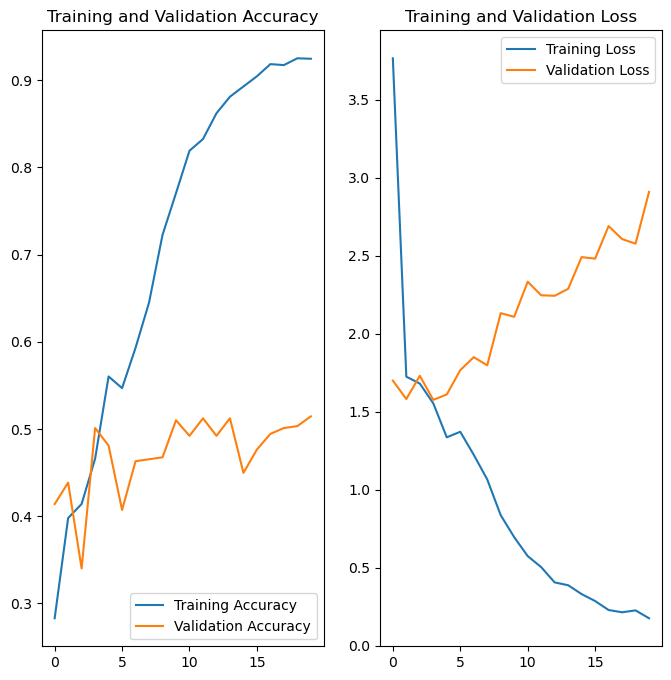

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### Write your findings here

_Findings: The train accuracy is at 93% and validation accuracy is at 51%. It indicates that the model is overfitting._

In [20]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy.
# Your code goes here
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

2025-01-15 13:31:04.321757: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


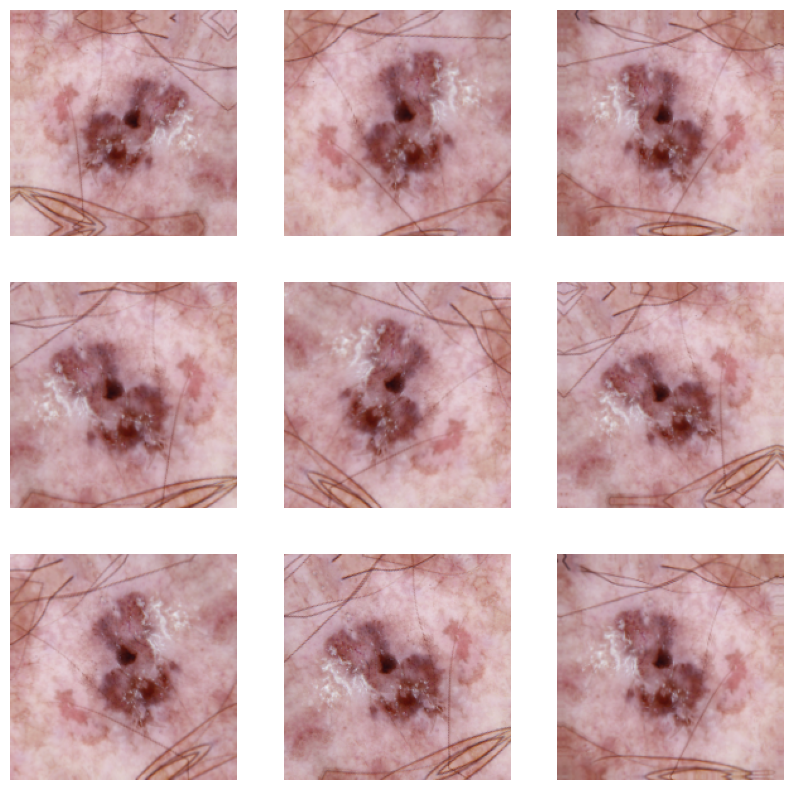

In [21]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

### Todo:
### Create the model, compile and train the model


In [22]:
num_classes = 9
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
validation_ds = validation_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [23]:
model = buildModel(input_shape, data_augmentation, 'relu', 'softmax', 0.25, [32, 64], False)

### Compiling the model

In [24]:
## Your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [25]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_1 (Sequential)       │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 178, 178, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 176, 176, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 88, 88, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 88, 88, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 495616)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │    63,438,976 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 63,459,529 (242.08 MB)

 Trainable params: 63,459,529 (242.08 MB)

 Non-trainable params: 0 (0.00 B)

### Training the model

In [26]:
## Your code goes here, note: train your model for 20 epochs
## history = ## your training code
epochs = 20
history = model.fit(
  train_ds,
  validation_data=validation_ds,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 41s 717ms/step - accuracy: 0.1951 - loss: 9.0888 - val_accuracy: 0.2550 - val_loss: 1.9362
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 39s 702ms/step - accuracy: 0.3188 - loss: 1.8654 - val_accuracy: 0.4139 - val_loss: 1.7704
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 39s 704ms/step - accuracy: 0.3909 - loss: 1.7583 - val_accuracy: 0.4430 - val_loss: 1.6501
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 39s 693ms/step - accuracy: 0.4291 - loss: 1.6700 - val_accuracy: 0.4944 - val_loss: 1.5589
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 39s 694ms/step - accuracy: 0.4453 - loss: 1.5635 - val_accuracy: 0.4430 - val_loss: 1.6253
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 40s 716ms/step - accuracy: 0.4566 - loss: 1.5663 - val_accuracy: 0.4989 - val_loss: 1.5702
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 38s 682ms/step - accuracy: 0.4841 - loss: 1.4936 - val_accuracy: 0.4966 - val_loss: 1.5693
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 38s 675ms/step - accuracy: 0.4925 - loss: 1.4565 - val_accu

### Visualizing the results

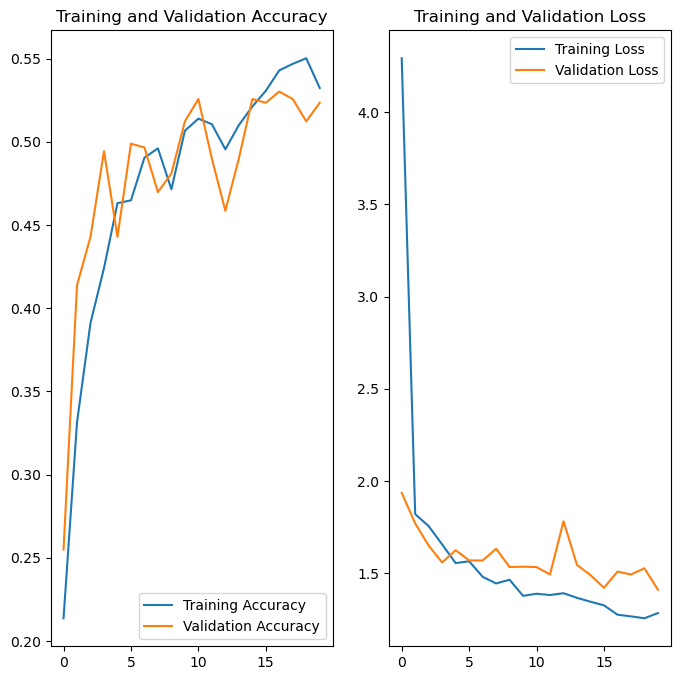

In [27]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?
_Findings: The training accuracy is 53% and validation accuracy is 52%, which means the model is not overfitting now, however the validation score is less, so Hyperparameter tuning or data augmentation is needed._

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [28]:
## Your code goes here.
from glob import glob
path_list = [x for x in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
lesion_list = [os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
len(path_list)

2239

In [29]:
dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df

,Path,Label
0,/Users/hkolavasi/Documents/playground/NN/CNN/m...,melanoma
1,/Users/hkolavasi/Documents/playground/NN/CNN/m...,melanoma
2,/Users/hkolavasi/Documents/playground/NN/CNN/m...,melanoma
3,/Users/hkolavasi/Documents/playground/NN/CNN/m...,melanoma
4,/Users/hkolavasi/Documents/playground/NN/CNN/m...,melanoma
...,...,...
2234,/Users/hkolavasi/Documents/playground/NN/CNN/m...,dermatofibroma
2235,/Users/hkolavasi/Documents/playground/NN/CNN/m...,dermatofibroma
2236,/Users/hkolavasi/Documents/playground/NN/CNN/m...,dermatofibroma
2237,/Users/hkolavasi/Documents/playground/NN/CNN/m...,dermatofibroma


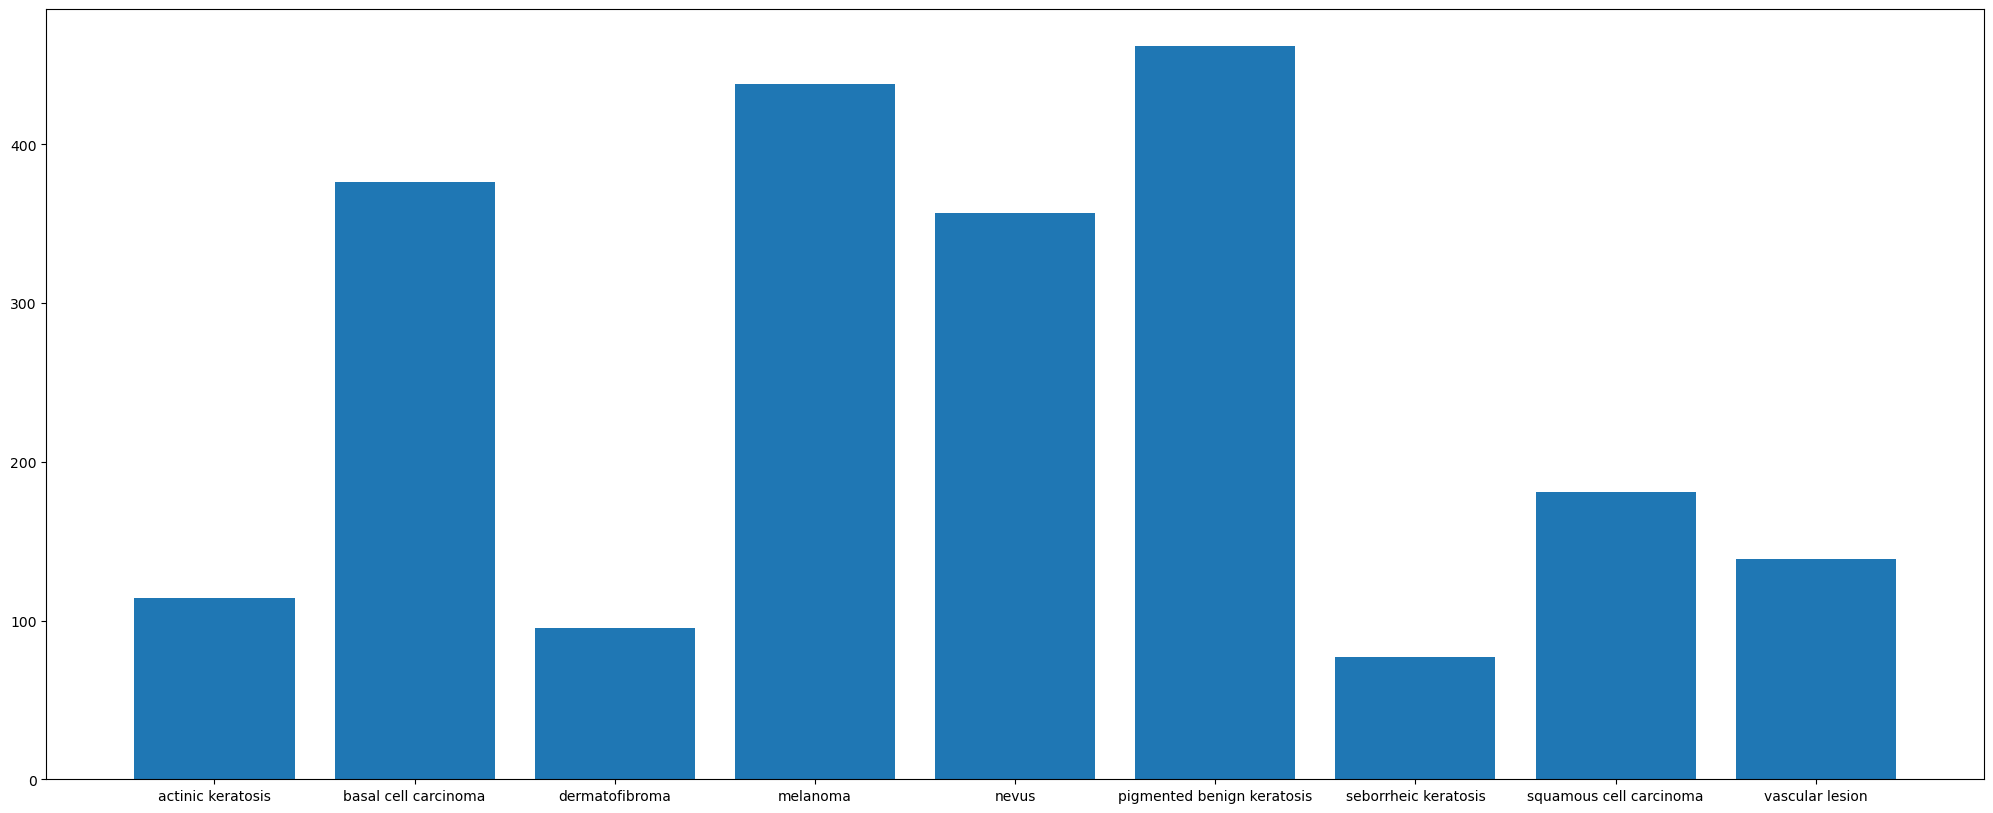

In [30]:
## Your code goes here.
count=[]
for i in class_names:
    count.append(len(list(data_dir_train.glob(i+'/*.jpg'))))
plt.figure(figsize=(25,10))
plt.bar(class_names,count)
plt.show()

In [31]:
from sklearn.preprocessing import LabelEncoder
from collections import Counter
# split into input and output elements
X, y = original_df['Path'], original_df['Label']
# label encode the target variable
y = LabelEncoder().fit_transform(y)
# summarize distribution
counter = Counter(y)
for k,v in counter.items():
	per = v / len(y) * 100
	print('Class=%s, n=%d percent=(%.3f%%)' % (class_names[k], v, per))

Class=melanoma, n=438 percent=(19.562%)
Class=pigmented benign keratosis, n=462 percent=(20.634%)
Class=nevus, n=357 percent=(15.945%)
Class=basal cell carcinoma, n=376 percent=(16.793%)
Class=actinic keratosis, n=114 percent=(5.092%)
Class=squamous cell carcinoma, n=181 percent=(8.084%)
Class=vascular lesion, n=139 percent=(6.208%)
Class=seborrheic keratosis, n=77 percent=(3.439%)
Class=dermatofibroma, n=95 percent=(4.243%)


#### **Todo:** Write your findings here:
#### - Which class has the least number of samples?
* __seborrheic keratosis__ class has the least number of samples (i.e., 3.44%)

#### - Which classes dominate the data in terms proportionate number of samples?
1. Pigmented bengin keratosis
2. melanoma
3. basal cell carcinoma

#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [32]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [50]:
path_to_training_dataset=root_path + "/melanoma_detection_assignment_final/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /Users/hkolavasi/Documents/playground/NN/CNN/melanoma_detection_assignment_final/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x365C8E210>: 100%|█|


Initialised with 376 image(s) found.
Output directory set to /Users/hkolavasi/Documents/playground/NN/CNN/melanoma_detection_assignment_final/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x15A34E480>: 100%|█|


Initialised with 95 image(s) found.
Output directory set to /Users/hkolavasi/Documents/playground/NN/CNN/melanoma_detection_assignment_final/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x32481FEC0>: 100%|█|


Initialised with 438 image(s) found.
Output directory set to /Users/hkolavasi/Documents/playground/NN/CNN/melanoma_detection_assignment_final/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=3072x2304 at 0x15AE47440>: 100%|


Initialised with 357 image(s) found.
Output directory set to /Users/hkolavasi/Documents/playground/NN/CNN/melanoma_detection_assignment_final/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=2117x1988 at 0x365C0AAB0>: 100%|


Initialised with 462 image(s) found.
Output directory set to /Users/hkolavasi/Documents/playground/NN/CNN/melanoma_detection_assignment_final/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x365CB7BF0>: 100%|█|


Initialised with 77 image(s) found.
Output directory set to /Users/hkolavasi/Documents/playground/NN/CNN/melanoma_detection_assignment_final/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x15AE9F860>: 100%|█


Initialised with 181 image(s) found.
Output directory set to /Users/hkolavasi/Documents/playground/NN/CNN/melanoma_detection_assignment_final/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x15A99E2A0>: 100%|█|


Initialised with 139 image(s) found.
Output directory set to /Users/hkolavasi/Documents/playground/NN/CNN/melanoma_detection_assignment_final/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x15AE44F80>: 100%|█|


Augmentor has stored the augmented images in the `output` sub-directory of each of the sub-directories of skin cancer types. Lets take a look at total count of augmented images.

In [57]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [58]:
from glob import glob

In [59]:
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new

['/Users/hkolavasi/Documents/playground/NN/CNN/melanoma_detection_assignment_final/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010319.jpg_2278f9a3-a097-458e-864a-0001661c67c6.jpg',
 '/Users/hkolavasi/Documents/playground/NN/CNN/melanoma_detection_assignment_final/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010240.jpg_9855fda9-e8a5-4737-b853-b52d459db63e.jpg',
 '/Users/hkolavasi/Documents/playground/NN/CNN/melanoma_detection_assignment_final/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0000174.jpg_3cd44993-77ee-4743-87a4-587f80204dba.jpg',
 '/Users/hkolavasi/Documents/playground/NN/CNN/melanoma_detection_assignment_final/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0009910.jpg_9975f607-6151-4139-866b-1991fc3758e2.jpg',
 '/Users/hkolavasi/D

In [60]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',

In [61]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [62]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df._append(df2)

In [63]:
new_df['Label'].value_counts()

Label
pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: count, dtype: int64

In [64]:
new_df.shape

(6739, 2)

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [65]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [66]:
data_dir_train=root_path + "/melanoma_detection_assignment_final/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training", ## Todo choose the correct parameter value, so that only training data is refered to,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [67]:
validation_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation", ## Todo choose the correct parameter value, so that only validation data is refered to,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [68]:
num_classes = 9
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
validation_ds = validation_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [69]:
model = buildModel(input_shape, None, 'relu', 'softmax', 0.25, [32, 64], True)

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [70]:
## your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
             metrics=['accuracy'])

In [71]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_3 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 178, 178, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 176, 176, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 88, 88, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 88, 88, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 495616)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │    63,438,976 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_1           │ (None, 128)            │           256 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 63,459,785 (242.08 MB)

 Trainable params: 63,459,785 (242.08 MB)

 Non-trainable params: 0 (0.00 B)

#### **Todo:**  Train your model

In [72]:
epochs = 30
## Your code goes here, use 30 epochs.
## history = # your model fit code
history = model.fit(
  train_ds,
  validation_data=validation_ds,
  epochs=epochs
)

Epoch 1/30


/opt/anaconda3/lib/python3.12/site-packages/keras/src/backend/tensorflow/nn.py:678: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


169/169 ━━━━━━━━━━━━━━━━━━━━ 125s 710ms/step - accuracy: 0.1311 - loss: 2.5242 - val_accuracy: 0.2487 - val_loss: 1.8847
Epoch 2/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 130s 765ms/step - accuracy: 0.3136 - loss: 1.7805 - val_accuracy: 0.4536 - val_loss: 1.4566
Epoch 3/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 123s 730ms/step - accuracy: 0.4996 - loss: 1.3457 - val_accuracy: 0.5011 - val_loss: 1.3089
Epoch 4/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 122s 722ms/step - accuracy: 0.6131 - loss: 1.0809 - val_accuracy: 0.6340 - val_loss: 1.0598
Epoch 5/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 119s 708ms/step - accuracy: 0.7279 - loss: 0.7710 - val_accuracy: 0.6763 - val_loss: 0.9027
Epoch 6/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 119s 705ms/step - accuracy: 0.8108 - loss: 0.5511 - val_accuracy: 0.7238 - val_loss: 0.8197
Epoch 7/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 116s 688ms/step - accuracy: 0.8660 - loss: 0.3949 - val_accuracy: 0.7261 - val_loss: 0.8339
Epoch 8/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 118s 698ms/step - accuracy: 0.8817 - loss: 0.35

#### **Todo:**  Visualize the model results

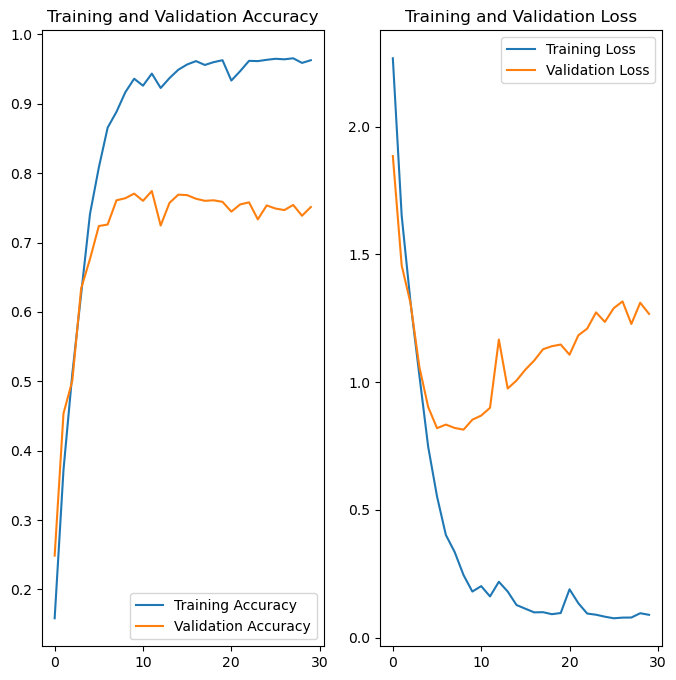

In [73]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



_Of course, the class rebalance did help. The accuracy significantly improved and the final accuracy is at 96% for Training and 75% for validation. However, overfitting seems still exists as the difference between accuracy and validation accuracy is 21%. Let's re'model' by adding an additional convolutional layer_

### Create the model, compile and train the model
#### **Todo:** Create a training dataset

In [74]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [75]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
validation_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [76]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
validation_ds = validation_ds.cache().prefetch(buffer_size=AUTOTUNE)

#### **Todo:** Create the model

In [81]:
# adding additional convolutional layer with 16 filters
model = buildModel(input_shape, None, 'relu', 'softmax', 0.25, [16, 32, 64], True)

#### **Todo:** Compile the model

In [82]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [83]:
# View the summary of all layers
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_5 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 178, 178, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 176, 176, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 174, 174, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 87, 87, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 87, 87, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 484416)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │    62,005,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_3           │ (None, 128)            │           256 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 62,030,377 (236.63 MB)

 Trainable params: 62,030,377 (236.63 MB)

 Non-trainable params: 0 (0.00 B)

#### **Todo:** Train the model

In [84]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=validation_ds,
  epochs=epochs
)

Epoch 1/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 142s 832ms/step - accuracy: 0.1385 - loss: 2.5209 - val_accuracy: 0.3801 - val_loss: 1.6458
Epoch 2/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 149s 884ms/step - accuracy: 0.4162 - loss: 1.5694 - val_accuracy: 0.4915 - val_loss: 1.4307
Epoch 3/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 139s 823ms/step - accuracy: 0.5527 - loss: 1.2298 - val_accuracy: 0.5976 - val_loss: 1.0998
Epoch 4/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 137s 812ms/step - accuracy: 0.6788 - loss: 0.9163 - val_accuracy: 0.7016 - val_loss: 0.8858
Epoch 5/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 130s 771ms/step - accuracy: 0.7759 - loss: 0.6439 - val_accuracy: 0.7149 - val_loss: 0.7980
Epoch 6/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 136s 801ms/step - accuracy: 0.8451 - loss: 0.4581 - val_accuracy: 0.7498 - val_loss: 0.7256
Epoch 7/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 134s 789ms/step - accuracy: 0.8772 - loss: 0.3427 - val_accuracy: 0.7639 - val_loss: 0.8212
Epoch 8/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 125s 741ms/step - accuracy: 0.9159 -

#### **Todo:** Visualize the model results

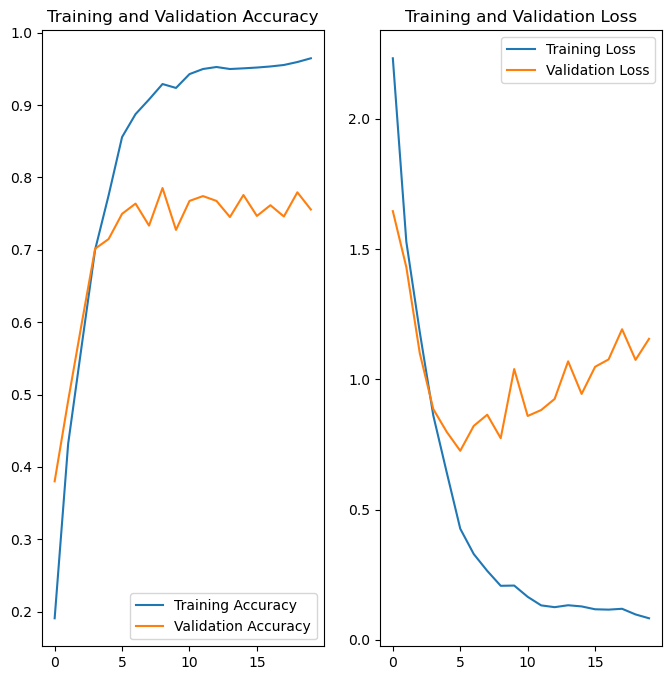

In [85]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:** Analyze the findings
_The validation accuracy slightly improved and the final accuracy is at 96% for training and 76% for validation._